In [269]:
AMOUNT = 360*26 #360 measurement points per hour * hours
sensor_id = [1,2,3,5,6,7,8,9,10,11]


In [270]:
# Imports & Inits

import polars as pl
from datetime import datetime
import asyncpg
import pendulum
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import math
import pyarrow as pa
import numpy as np

data = {
        "integer": [],
        "date": [],
        "system name": [],
        "variant": [],
        "CO2_raw": [],
        "CO2_compensated": [],
        "CO2_filtered": [],
        "sht45_humidity": [],
        "bme280_humidity": [],
        "bme280_pressure": [],
        "sht45_temperature": [],
        "bme280_temperature": [],
        "chamber_temperature": [],
        "gas_bottle_id": [],
        "speed_avg": [],
        "speed_max": [],
        "speed_min": [],
        "direction_avg": [],
        "direction_max": [],
        "direction_min": [],
        "last_update_time": [],
        "cpu_usage": [],
        "disk_usage": [],
        "memory_usage": [],
        "cpu_temperature": [],
        "enclosure_humidity": [],
        "enclosure_pressure": [],
        "mainboard_temperature": [],
        }

def plot_sensor_measurement(df, variant: str, col_name: str, sensor_id: list=sensor_id, filter = None):

        for id in sensor_id:
                df_f = df.filter(pl.col("variant") == variant).filter(pl.col("system name") == f"tum-esm-midcost-raspi-{id}").sort("date").filter(pl.col(col_name) > 0).select(pl.col("date",col_name))
                
                if filter != None:
                        df_f = df_f.groupby_dynamic("date",every=filter).agg(pl.all().exclude('date').mean())

                sns.lineplot(data=df_f,
                        x='date',
                        y=col_name)


        # set axes labels
        plt.xlabel('Time')
        plt.ylabel(col_name)
        plt.xticks(rotation=45)
        plt.legend(title='Systems', labels=sensor_id, bbox_to_anchor=(1, 1))
        plt.title(label=col_name)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

        # show the plot
        plt.show()

def plot_wind_rose(df, id):
    df_w = df.filter(pl.col("variant")== "wind").filter(pl.col("system name") == f"tum-esm-midcost-raspi-{id}")
    df_w = df_w.with_columns(pl.col("direction_avg").apply(find_closest_cardinal_direction, return_dtype=float).alias("cardinal_direction"))
    df_w = df_w.with_columns(pl.col("speed_avg").apply(lambda t: math.ceil(t * 2) / 2, return_dtype=float).alias("strength"))
    df_w = df_w.groupby(["cardinal_direction", "strength"]).count().sort("strength")

    fig = px.bar_polar(df_w, r="count", theta="cardinal_direction",
                    color="strength", template="seaborn")

    fig.add_annotation(
        text="Calm", x=0.5, y=0.5, showarrow=False, font=dict(size=7)
    )

    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="middle",  
        y=-0.1,
        xanchor="center",
        x=0.5,
        font=dict(
            size=14)),
        polar=dict(hole=0.1, radialaxis=dict(showticklabels=False, ticks='', linewidth=0)
                ),
        margin=dict(t=110),
        title=dict(
            text='Wind Speed Distribution <br> for the past 26h',
            xanchor='center',
            yanchor='top'
        ),
    )
    fig.show()
        
        
def find_closest_cardinal_direction(degree):
    # Normalize the degree value to be between 0 and 360
    degree = degree % 360

    # Define the cardinal and intermediate directions and their corresponding degrees
    directions = {
        'North': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'East': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'South': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'West': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5
    }

    # Initialize variables to keep track of the closest direction and its degree difference
    closest_direction = None
    min_difference = float('inf')

    # Iterate over the directions and calculate the difference in degrees
    for direction, direction_degree in directions.items():
        difference = abs(degree - direction_degree)

        # Check if the current difference is smaller than the previous minimum difference
        if difference < min_difference:
            min_difference = difference
            closest_direction = direction

    return directions[closest_direction]


In [271]:
# Database connection
f = open('config.json')
CONFIGURATION = json.load(f)

# Connect to the database
client = await asyncpg.connect(**CONFIGURATION)

# Automatically encode/decode JSONB fields to/from dict
await client.set_type_codec(
    typename="jsonb",
    schema="pg_catalog",
    encoder=json.dumps,
    decoder=json.loads,
)
# Automatically encode/decode UUID fields to/from str
await client.set_type_codec(
    typename="uuid",
    schema="pg_catalog",
    encoder=str,
    decoder=str,
)
# Automatically encode/decode TIMSTAMPTZ fields to/from pendulum.DateTime
await client.set_type_codec(
    typename="timestamptz",
    schema="pg_catalog",
    encoder=lambda x: x.isoformat(),
    decoder=pendulum.parse,
)


def pp(result):
    """Pretty print asynpg query results as JSON strings."""
    for entry in result:
        entry = dict(entry)
        for key, value in entry.items():
            # Print unix timestamps as human-readable dates in Europe/Berlin time zone
            if isinstance(entry[key], pendulum.DateTime):
                entry[key] = entry[key].in_timezone('Europe/Berlin').to_rfc1123_string()
        print(json.dumps(entry, indent=4))

In [272]:
# fetch all sensor data from sensor_id list and x hours
n_0 = 0
 
for id in sensor_id:
       
        # Receive measurements from the last x hours
        result = await client.fetch("""
        SELECT
                sensor.name,
                measurement.creation_timestamp,
                measurement.receipt_timestamp,
                measurement.revision,
                measurement.value
        FROM sensor
        JOIN measurement ON sensor.identifier = measurement.sensor_identifier
        WHERE name = $1
        ORDER BY creation_timestamp DESC
        LIMIT $2
        """, f'tum-esm-midcost-raspi-{id}', AMOUNT,)

        # Load data into a dataframe
        for n,entry in enumerate(result[::-1]):
                entry = dict(entry)
                #print(entry)
                if entry["value"]["variant"] in ("measurement","calibration"):
                        # base
                        data["integer"].append(n+n_0)
                        data["date"].append(entry["creation_timestamp"])
                        data["system name"].append(entry["name"])
                        data["variant"].append(entry["value"]["variant"])
                        #variant measurement & calibrtion
                        data["CO2_raw"].append(entry["value"]["data"]["raw"])
                        data["CO2_compensated"].append(entry["value"]["data"]["compensated"])
                        data["CO2_filtered"].append(entry["value"]["data"]["compensated"])
                        data["sht45_humidity"].append(entry["value"]["data"]["sht45_humidity"])
                        data["bme280_humidity"].append(entry["value"]["data"]["bme280_humidity"])
                        data["bme280_pressure"].append(entry["value"]["data"]["bme280_pressure"])
                        data["sht45_temperature"].append(entry["value"]["data"]["sht45_temperature"])
                        data["bme280_temperature"].append(entry["value"]["data"]["bme280_temperature"])
                        data["chamber_temperature"].append(entry["value"]["data"]["chamber_temperature"])
                        
                        if entry["value"]["variant"] == "calibration":
                                data["gas_bottle_id"].append(entry["value"]["data"]["gas_bottle_id"])
                        else:
                                data["gas_bottle_id"].append(None)
                        # variant wind     
                        data["speed_avg"].append(None)
                        data["speed_max"].append(None)
                        data["speed_min"].append(None)
                        data["direction_avg"].append(None)
                        data["direction_max"].append(None)
                        data["direction_min"].append(None)
                        data["last_update_time"].append(None)
                        # variant system
                        data["cpu_usage"].append(None)
                        data["disk_usage"].append(None)
                        data["memory_usage"].append(None)
                        data["cpu_temperature"].append(None)
                        data["enclosure_humidity"].append(None)
                        data["enclosure_pressure"].append(None)
                        data["mainboard_temperature"].append(None)
                        
                if entry["value"]["variant"] == "wind":
                        # base
                        data["integer"].append(n+n_0)
                        data["date"].append(entry["creation_timestamp"])
                        data["system name"].append(entry["name"])
                        data["variant"].append(entry["value"]["variant"])
                        #variant measurement & calibrtion
                        data["CO2_raw"].append(None)
                        data["CO2_compensated"].append(None)
                        data["CO2_filtered"].append(None)
                        data["sht45_humidity"].append(None)
                        data["bme280_humidity"].append(None)
                        data["bme280_pressure"].append(None)
                        data["sht45_temperature"].append(None)
                        data["bme280_temperature"].append(None)
                        data["chamber_temperature"].append(None)
                        data["gas_bottle_id"].append(None)
                        # variant wind
                        data["speed_avg"].append(entry["value"]["data"]["speed_avg"])
                        data["speed_max"].append(entry["value"]["data"]["speed_max"])
                        data["speed_min"].append(entry["value"]["data"]["speed_min"])
                        data["direction_avg"].append(entry["value"]["data"]["direction_avg"])
                        data["direction_max"].append(entry["value"]["data"]["direction_max"])
                        data["direction_min"].append(entry["value"]["data"]["direction_min"])
                        data["last_update_time"].append(entry["value"]["data"]["last_update_time"])
                        # variant system
                        data["cpu_usage"].append(None)
                        data["disk_usage"].append(None)
                        data["memory_usage"].append(None)
                        data["cpu_temperature"].append(None)
                        data["enclosure_humidity"].append(None)
                        data["enclosure_pressure"].append(None)
                        data["mainboard_temperature"].append(None)
                        
                if entry["value"]["variant"] == "system":
                        # base
                        data["integer"].append(n+n_0)
                        data["date"].append(entry["creation_timestamp"])
                        data["system name"].append(entry["name"])
                        data["variant"].append(entry["value"]["variant"])
                        #variant measurement & calibrtion
                        data["CO2_raw"].append(None)
                        data["CO2_compensated"].append(None)
                        data["CO2_filtered"].append(None)
                        data["sht45_humidity"].append(None)
                        data["bme280_humidity"].append(None)
                        data["bme280_pressure"].append(None)
                        data["sht45_temperature"].append(None)
                        data["bme280_temperature"].append(None)
                        data["chamber_temperature"].append(None)
                        data["gas_bottle_id"].append(None)
                        # variant wind
                        data["speed_avg"].append(None)
                        data["speed_max"].append(None)
                        data["speed_min"].append(None)
                        data["direction_avg"].append(None)
                        data["direction_max"].append(None)
                        data["direction_min"].append(None)
                        data["last_update_time"].append(None)
                        # variant system
                        data["cpu_usage"].append(entry["value"]["data"]["cpu_usage"])
                        data["disk_usage"].append(entry["value"]["data"]["disk_usage"])
                        data["memory_usage"].append(entry["value"]["data"]["memory_usage"])
                        data["cpu_temperature"].append(entry["value"]["data"]["cpu_temperature"])
                        data["enclosure_humidity"].append(entry["value"]["data"]["enclosure_humidity"])
                        data["enclosure_pressure"].append(entry["value"]["data"]["enclosure_pressure"])
                        data["mainboard_temperature"].append(entry["value"]["data"]["mainboard_temperature"])
                        
        n_0 += n
        
df = pl.DataFrame(data)
df.head()
        

integer,date,system name,variant,CO2_raw,CO2_compensated,CO2_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,chamber_temperature,gas_bottle_id,speed_avg,speed_max,speed_min,direction_avg,direction_max,direction_min,last_update_time,cpu_usage,disk_usage,memory_usage,cpu_temperature,enclosure_humidity,enclosure_pressure,mainboard_temperature
i64,datetime[μs],str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,2023-07-16 13:51:57.460,"""tum-esm-midcos…","""measurement""",377.6,428.4,428.4,41.27,38.87,936.64,30.58,30.55,32.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1,2023-07-16 13:52:07.420,"""tum-esm-midcos…","""measurement""",380.3,430.3,430.3,41.27,38.87,938.64,30.6,30.57,32.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2,2023-07-16 13:52:17.470,"""tum-esm-midcos…","""measurement""",378.8,427.6,427.6,41.28,38.95,940.34,30.61,30.56,32.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3,2023-07-16 13:52:27.430,"""tum-esm-midcos…","""measurement""",380.7,432.0,432.0,41.32,38.97,936.55,30.59,30.56,32.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
4,2023-07-16 13:52:37.490,"""tum-esm-midcos…","""measurement""",380.4,429.0,429.0,41.36,39.03,940.91,30.6,30.56,32.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


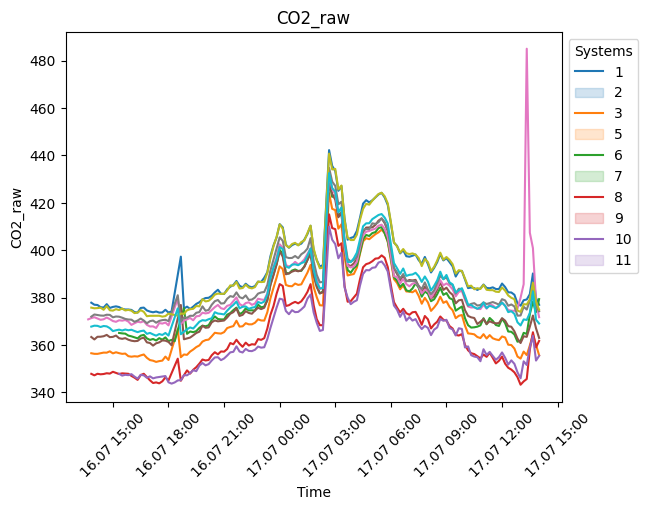

In [273]:
plot_sensor_measurement(df,col_name="CO2_raw",variant="measurement",sensor_id=sensor_id,filter='10m')

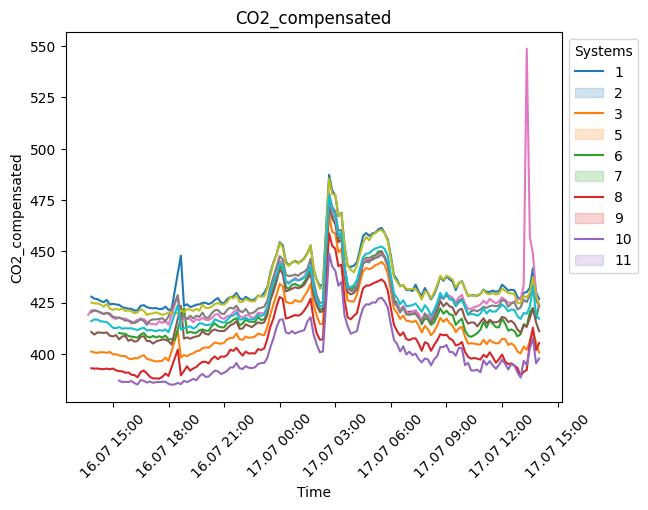

In [274]:
plot_sensor_measurement(df,col_name="CO2_compensated",variant="measurement",sensor_id=sensor_id,filter='10m')

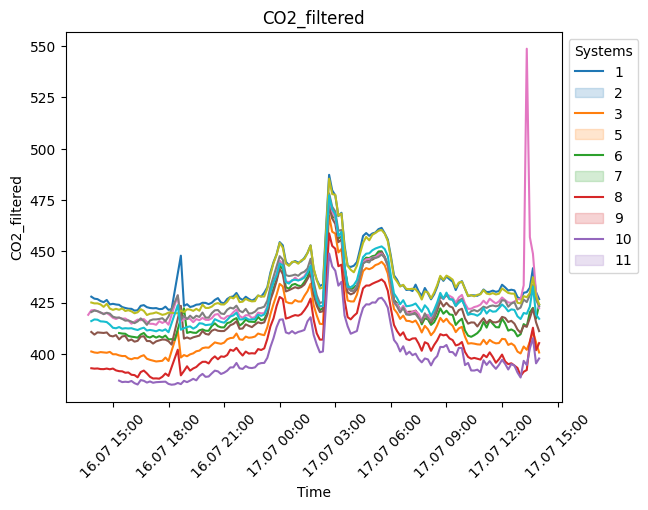

In [275]:
plot_sensor_measurement(df,col_name="CO2_filtered",variant="measurement",sensor_id=sensor_id,filter='10m')

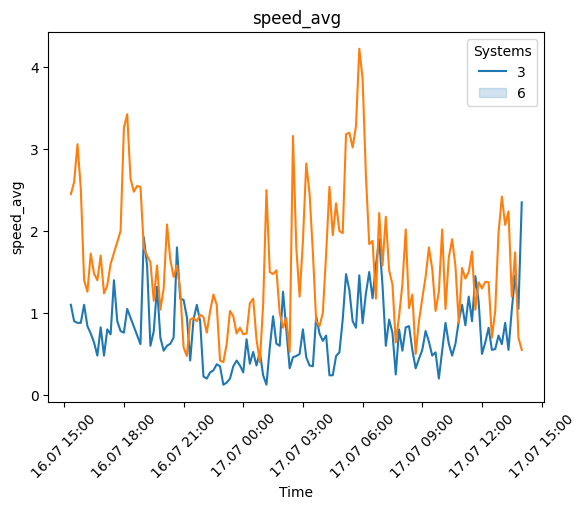

In [276]:
plot_sensor_measurement(df,col_name="speed_avg",variant="wind",sensor_id=[3,6],filter='10m')

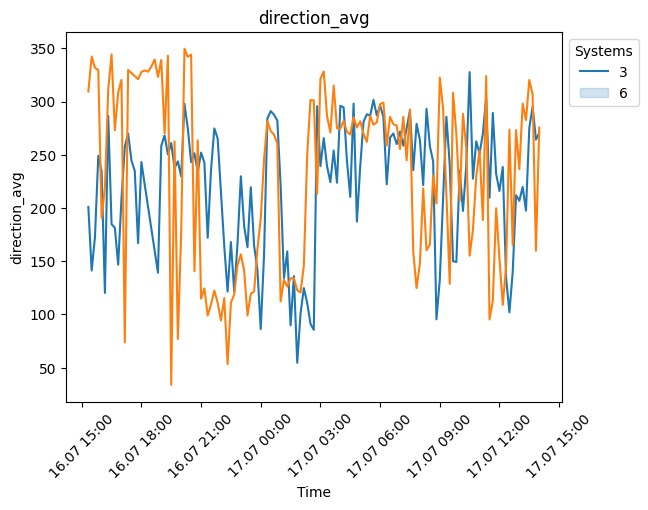

In [277]:
plot_sensor_measurement(df,col_name="direction_avg",variant="wind",sensor_id=[3,6],filter='10m')

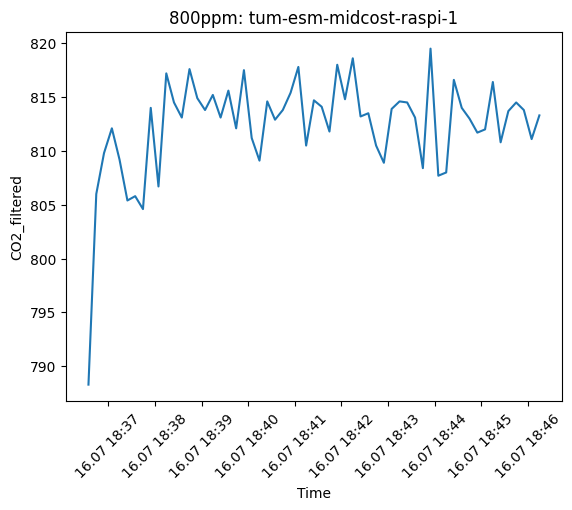

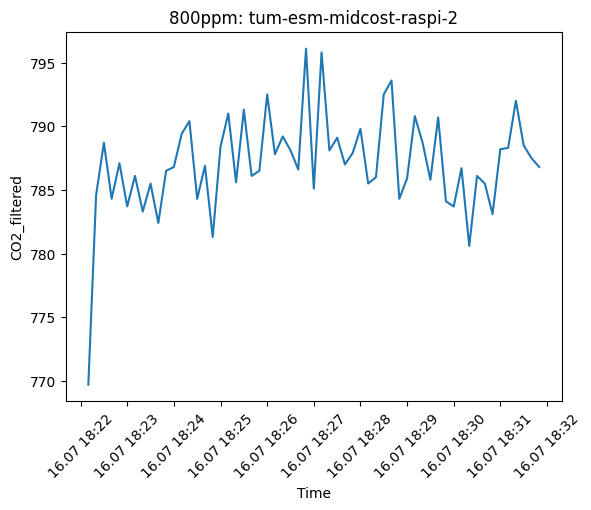

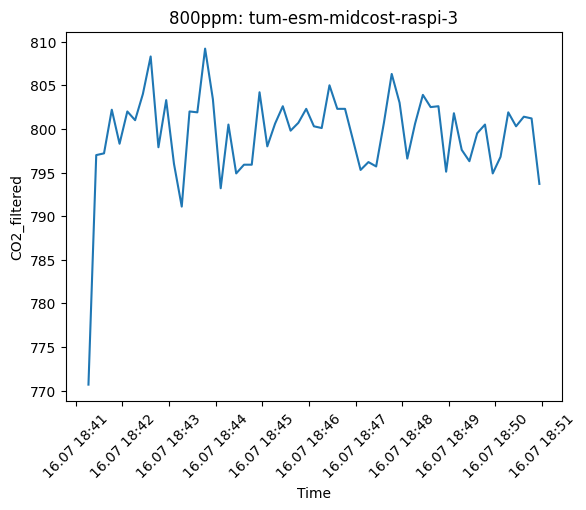

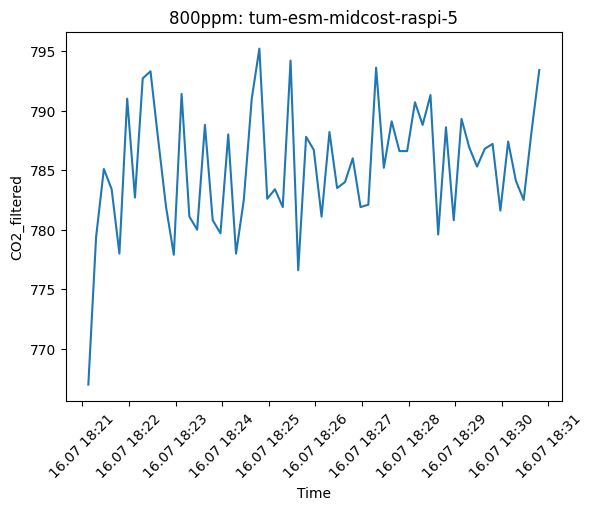

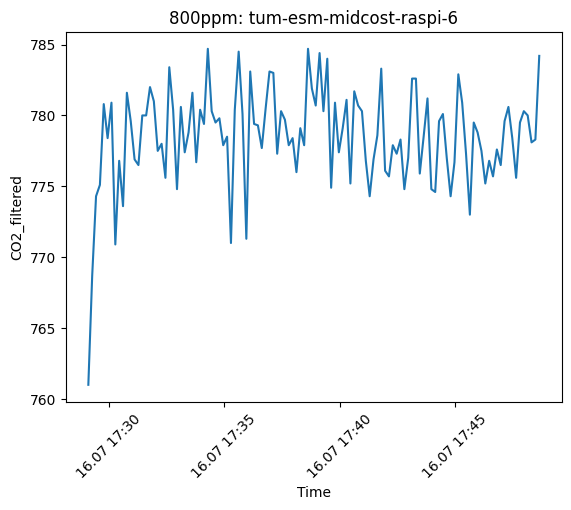

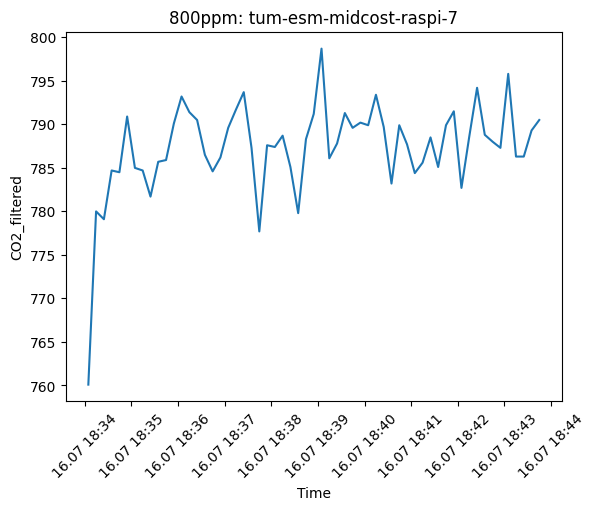

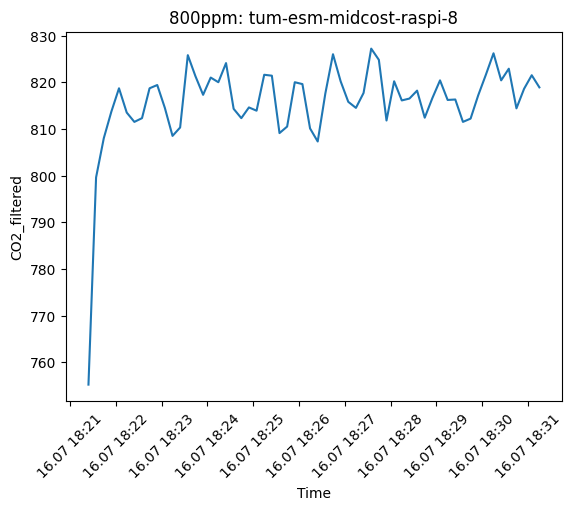

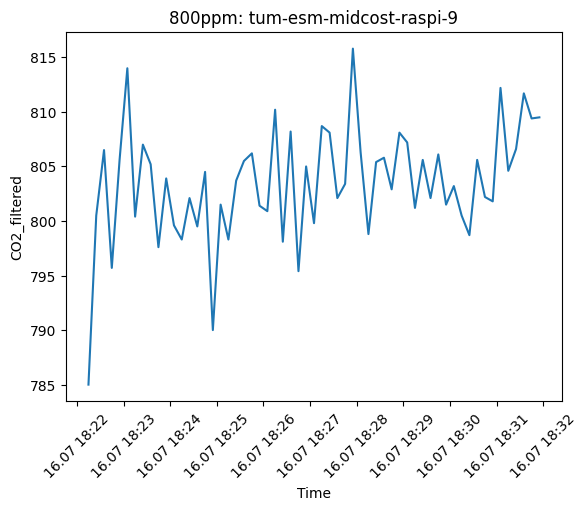

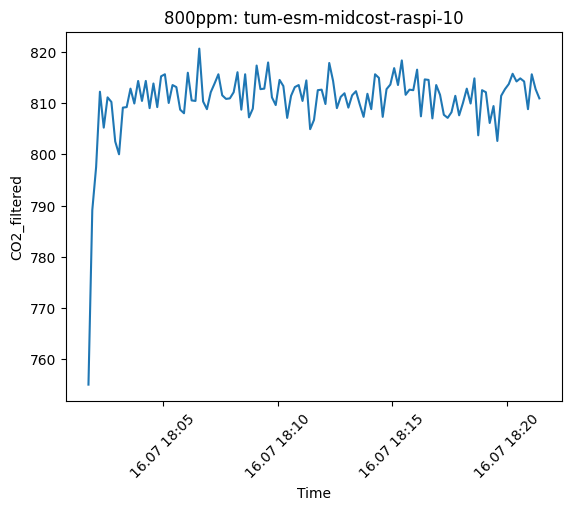

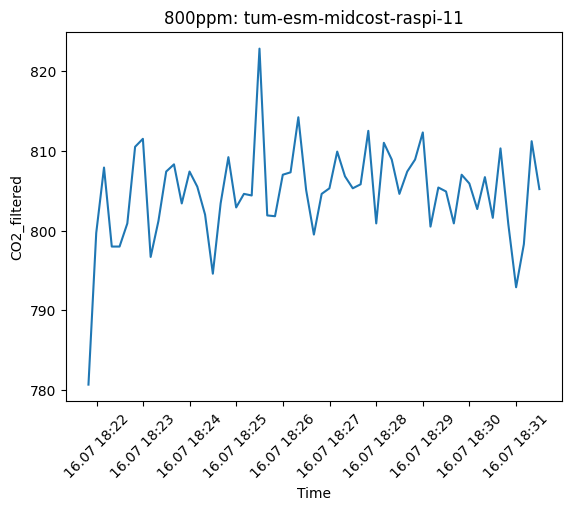

In [278]:
# Plot 400ppm Calibration Bottle 
filter = None #examples None, '30s', '10m', '1h'
variant = "calibration"
col_name = "CO2_filtered"

for id in sensor_id:
    df_f = df.filter(pl.col("variant") == variant).filter(pl.col("system name") == f"tum-esm-midcost-raspi-{id}").sort("date").filter(pl.col(col_name) > 750).select(pl.col("date",col_name))
    
    if filter != None:
            df_f = df_f.groupby_dynamic("date",every=filter).agg(pl.all().exclude('date').mean())

    sns.lineplot(data=df_f,
            x='date',
            y=col_name)


    # set axes labels
    plt.xlabel('Time')
    plt.ylabel(col_name)
    plt.xticks(rotation=45)
    plt.title(label=f"800ppm: tum-esm-midcost-raspi-{id}")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

    # show the plot
    plt.show()

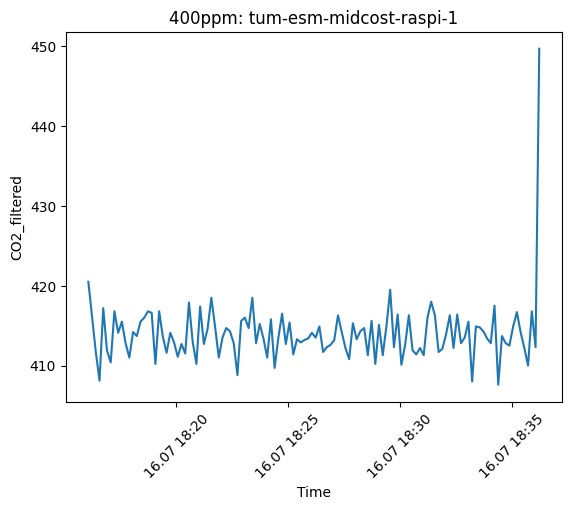

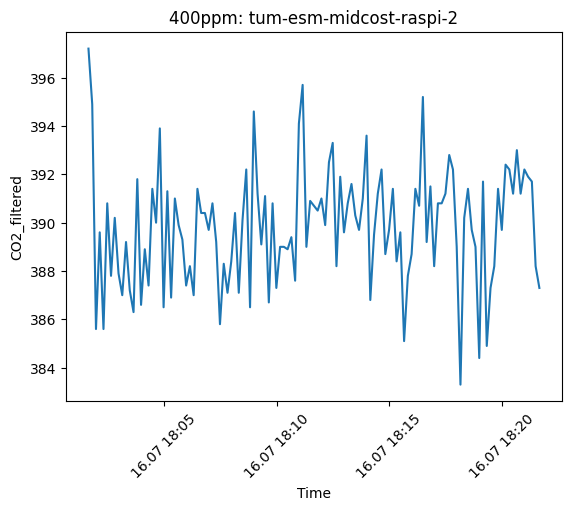

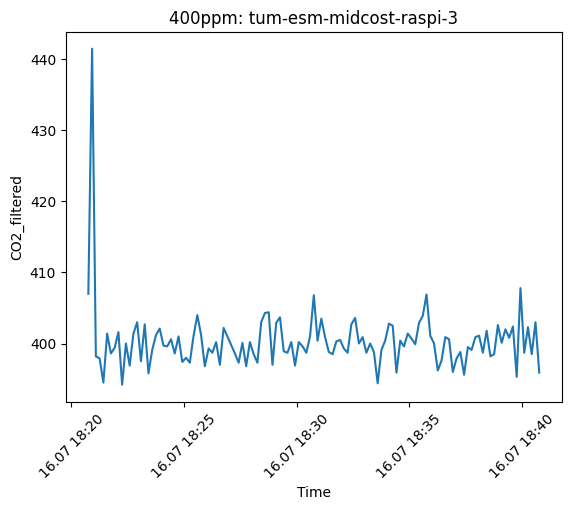

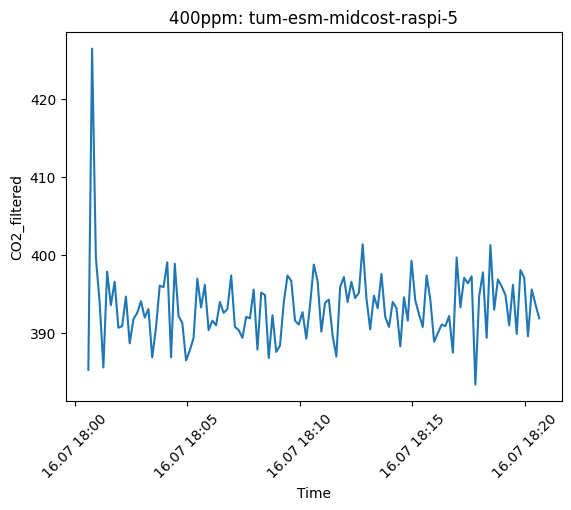

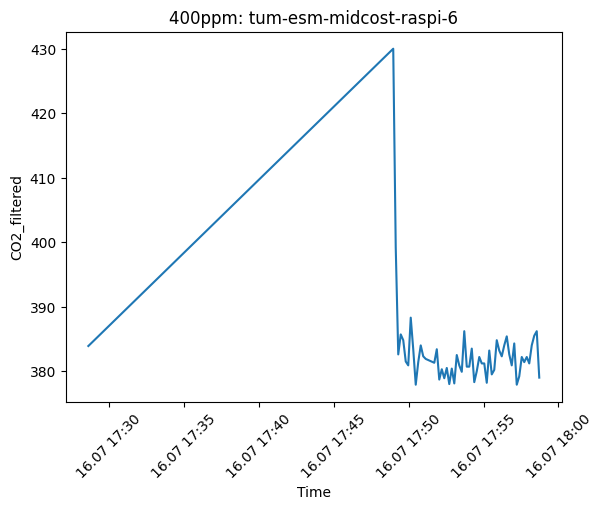

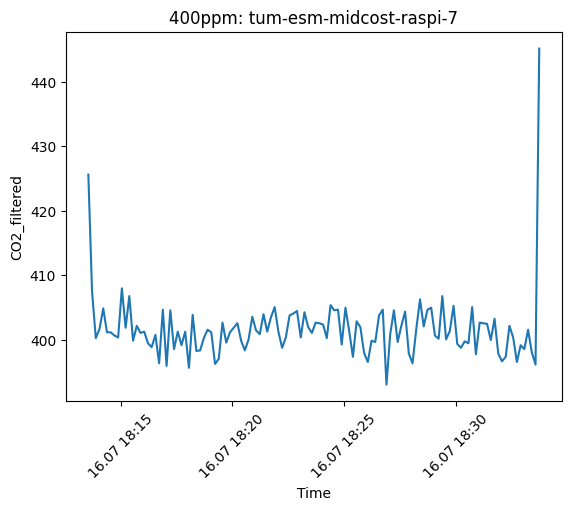

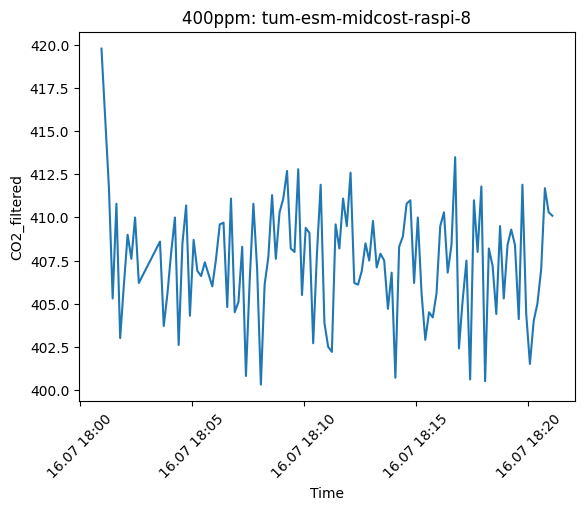

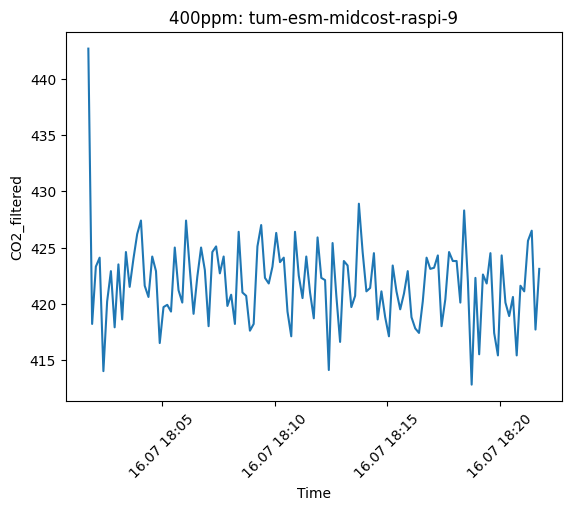

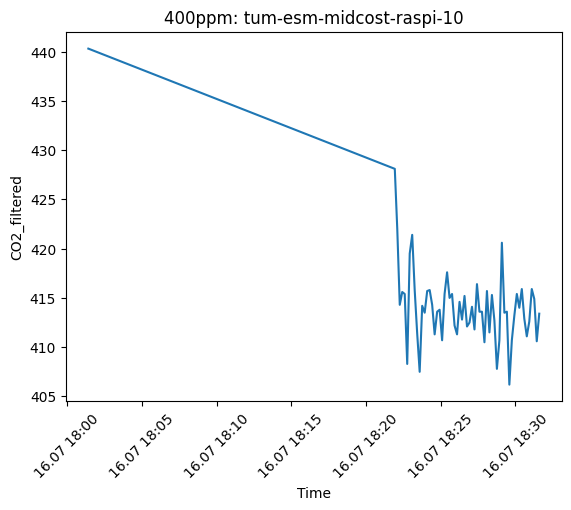

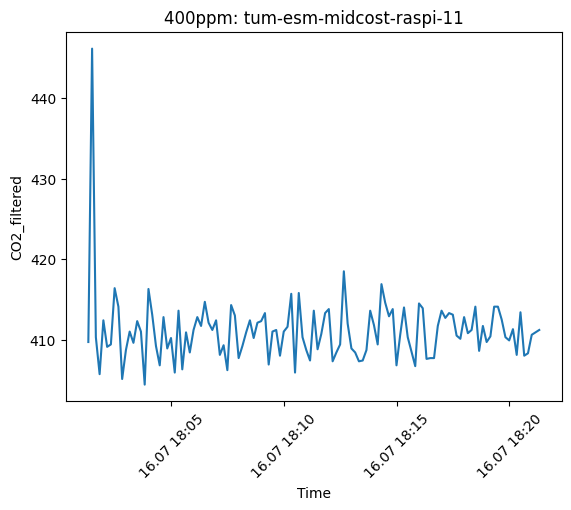

In [279]:
# Plot 400ppm Calibration Bottle 
filter = None #examples None, '30s', '10m', '1h'
variant = "calibration"
col_name = "CO2_filtered"

for id in sensor_id:
    df_f = df.filter(pl.col("variant") == variant).filter(pl.col("system name") == f"tum-esm-midcost-raspi-{id}").sort("date").filter(pl.col(col_name) > 350).filter(pl.col(col_name) < 450).select(pl.col("date",col_name))
    
    if filter != None:
            df_f = df_f.groupby_dynamic("date",every=filter).agg(pl.all().exclude('date').mean())

    sns.lineplot(data=df_f,
            x='date',
            y=col_name)


    # set axes labels
    plt.xlabel('Time')
    plt.ylabel(col_name)
    plt.xticks(rotation=45)
    plt.title(label=f"400ppm: tum-esm-midcost-raspi-{id}")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))

    # show the plot
    plt.show()

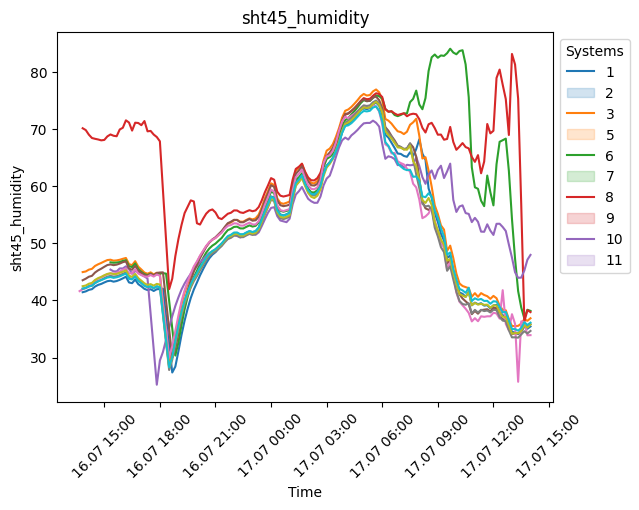

In [280]:
# Plot auxilliary data
plot_sensor_measurement(df,col_name="sht45_humidity",variant="measurement",sensor_id=sensor_id,filter='10m')


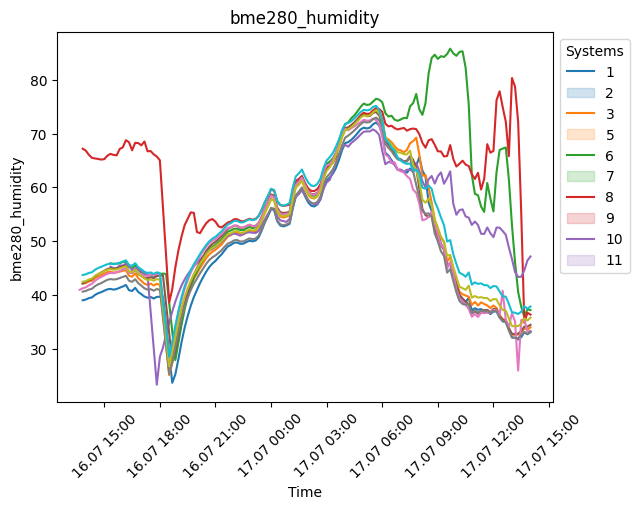

In [281]:
plot_sensor_measurement(df,col_name="bme280_humidity",variant="measurement",sensor_id=sensor_id,filter='10m')

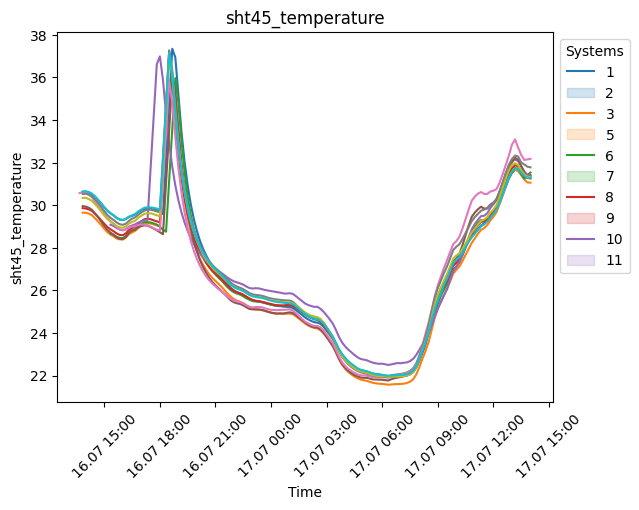

In [282]:
plot_sensor_measurement(df,col_name="sht45_temperature",variant="measurement",sensor_id=sensor_id,filter='10m')

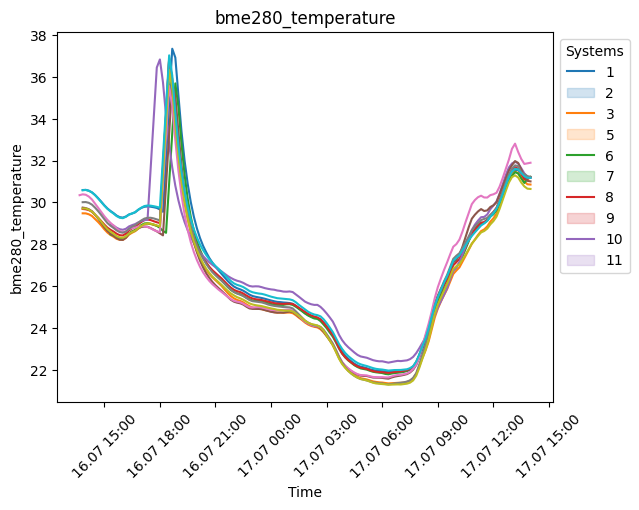

In [283]:
plot_sensor_measurement(df,col_name="bme280_temperature",variant="measurement",sensor_id=sensor_id,filter='10m')

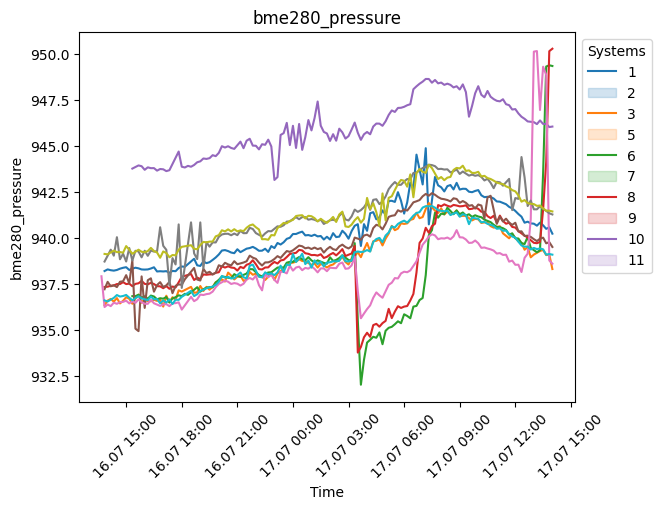

In [284]:
plot_sensor_measurement(df,col_name="bme280_pressure",variant="measurement",sensor_id=sensor_id,filter='10m')

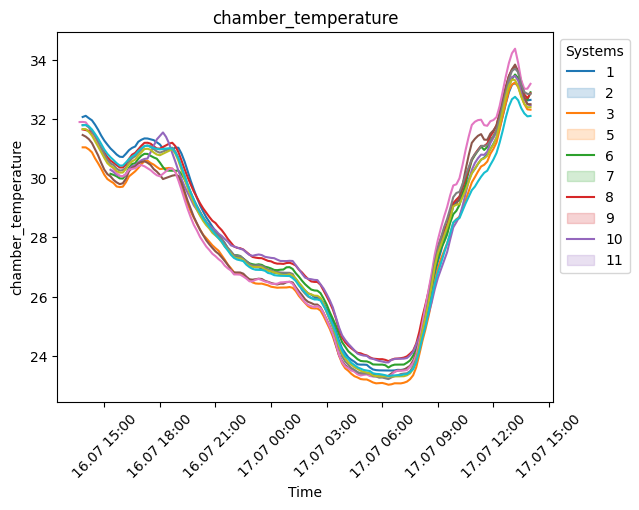

In [285]:
plot_sensor_measurement(df,col_name="chamber_temperature",variant="measurement",sensor_id=sensor_id,filter='10m')

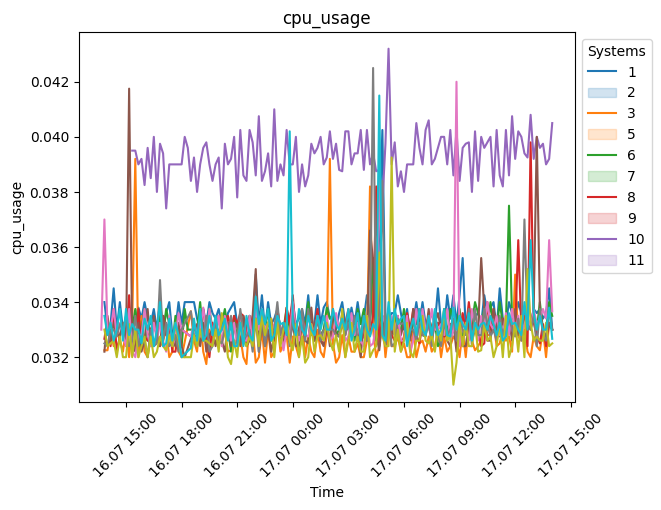

In [286]:
plot_sensor_measurement(df,col_name="cpu_usage",variant="system",sensor_id=sensor_id,filter='10m')

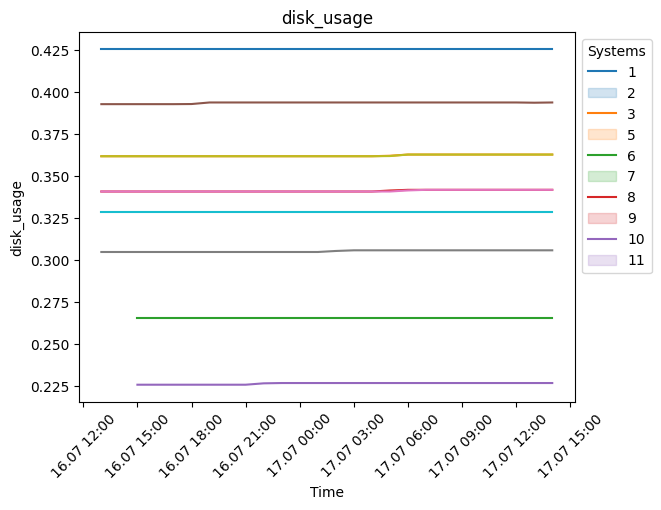

In [287]:
plot_sensor_measurement(df,col_name="disk_usage",variant="system",sensor_id=sensor_id,filter='1h')

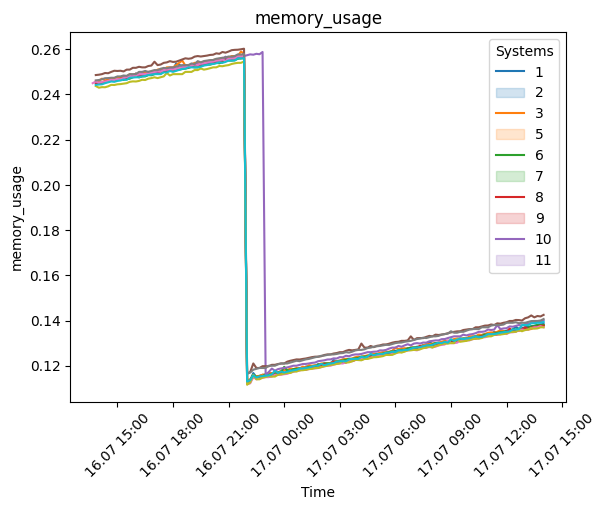

In [288]:
plot_sensor_measurement(df,col_name="memory_usage",variant="system",sensor_id=sensor_id,filter='10m')

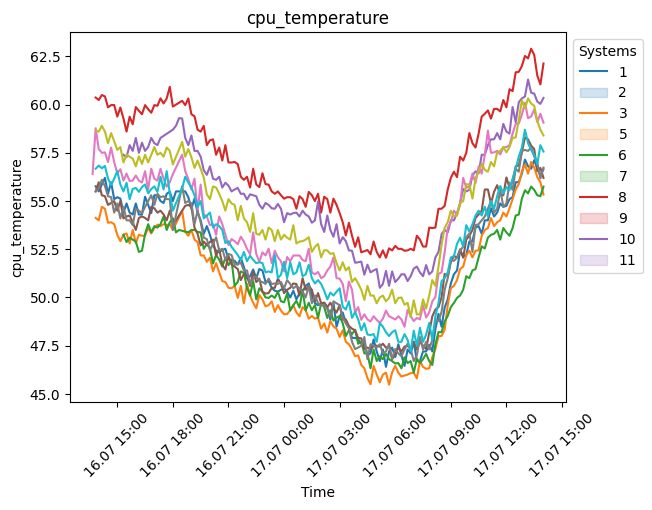

In [289]:
plot_sensor_measurement(df,col_name="cpu_temperature",variant="system",sensor_id=sensor_id,filter='10m')

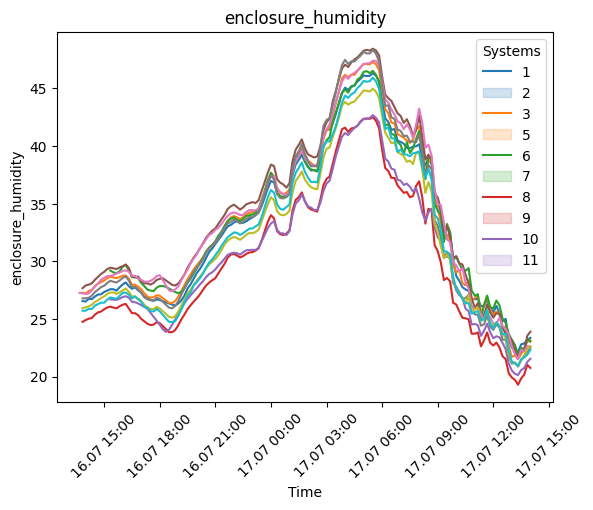

In [290]:
plot_sensor_measurement(df,col_name="enclosure_humidity",variant="system",sensor_id=sensor_id,filter='10m')

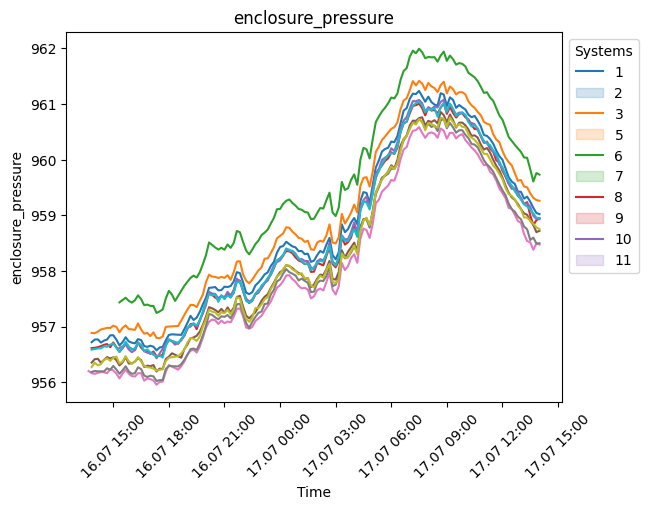

In [291]:
plot_sensor_measurement(df,col_name="enclosure_pressure",variant="system",sensor_id=sensor_id,filter='10m')

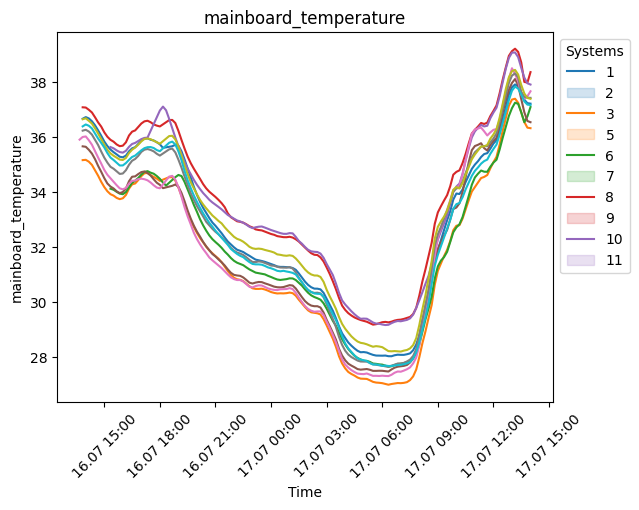

In [292]:
plot_sensor_measurement(df,col_name="mainboard_temperature",variant="system",sensor_id=sensor_id,filter='10m')

In [293]:
# plot wind at site-by-site inlets
plot_wind_rose(df,3)

In [294]:
# plot wind at 3m pole inlet
plot_wind_rose(df,6)

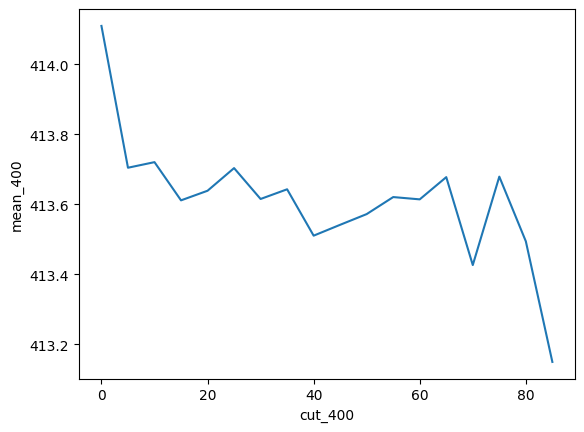

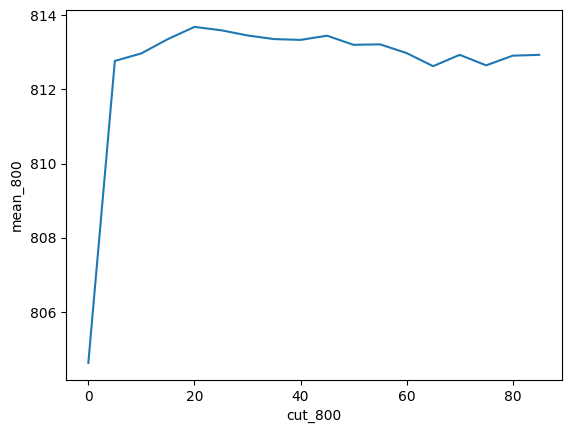

In [295]:
filter = None #examples None, '30s', '10m', '1h'
variant = "calibration"
col_name = "CO2_filtered"

mean_list_400 = []
percent_list_400 = []
mean_list_800 = []
percent_list_800 = []

data_cal = {
        "mean_400": [],
        "cut_400": [],
        "mean_800": [],
        "cut_800": [],}

#400
df_test = df.filter(pl.col("variant") == variant).filter(pl.col("system name") == f"tum-esm-midcost-raspi-1").sort("date").filter(pl.col("gas_bottle_id") == '6').select(pl.col("date",col_name))

i = len(df_test)

math.floor(i*0.30)

for percent in range(0,90,5):
    mean = pl.mean(df_test[math.floor(i*(percent/100)):math.floor(i*0.95)]["CO2_filtered"])
    data_cal["mean_400"].append(mean)
    data_cal["cut_400"].append(percent)

#800
df_test = df.filter(pl.col("variant") == variant).filter(pl.col("system name") == f"tum-esm-midcost-raspi-1").sort("date").filter(pl.col("gas_bottle_id") == '2').select(pl.col("date",col_name))

i = len(df_test)
math.floor(i*0.30)

for percent in range(0,90,5):
    mean = pl.mean(df_test[math.floor(i*(percent/100)):math.floor(i*0.95)]["CO2_filtered"])
    data_cal["mean_800"].append(mean)
    data_cal["cut_800"].append(percent)
    
 
df_cal = pl.DataFrame(data_cal)

sns.lineplot(data=df_cal,x='cut_400',y="mean_400")
plt.show()
sns.lineplot(data=df_cal,x='cut_800',y="mean_800")
plt.show()


